# Geographical Demand Patterns

## In this document, we analyze which bikesharing stations are the most and least popular.

### The datasets we use are: 
#### Main dataset:
- Chicago2016.csv

#### Additional dataset:
- Divvy_Stations_2016_Q1Q2.csv
- source: https://divvy-tripdata.s3.amazonaws.com/index.html

We use the additional dataset to explain the observed patterns (popularity of certain sharing stations).
The datasets describe the sharing stations and provide geographical data.

In [2]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap

In [21]:
# loading the main dataset

chicago_data = pd.read_csv("chicago_2016.csv", sep=",",parse_dates=["start_time"])

First of all we need to find out what we are working with...

In [22]:
# getting info on the main dataset

chicago_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595383 entries, 0 to 3595382
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_time          datetime64[ns]
 1   end_time            object        
 2   start_station_id    int64         
 3   end_station_id      int64         
 4   start_station_name  object        
 5   end_station_name    object        
 6   bike_id             int64         
 7   user_type           object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 219.4+ MB


In [23]:
# displaying the first rows of the main dataset

chicago_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-03-31 23:53:00,4/1/2016 0:07,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber
1,2016-03-31 23:46:00,3/31/2016 23:57,128,213,Damen Ave & Chicago Ave,Leavitt St & North Ave,4831,Subscriber
2,2016-03-31 23:42:00,3/31/2016 23:46,350,210,Ashland Ave & Chicago Ave,Ashland Ave & Division St,4232,Subscriber
3,2016-03-31 23:37:00,3/31/2016 23:55,303,458,Broadway & Cornelia Ave,Broadway & Thorndale Ave,3464,Subscriber
4,2016-03-31 23:33:00,3/31/2016 23:37,334,329,Lake Shore Dr & Belmont Ave,Lake Shore Dr & Diversey Pkwy,1750,Subscriber


To properly analyze and explain our data, we need to import a second dataset, which provides further data such as coordinates and number of trips for each station.

In [24]:
# loading the additional dataset
coordinates = pd.read_csv("Divvy_Stations_2016_Q1Q2.csv", sep=",")

# counting the number of start and end stations
start_count = chicago_data["start_station_name"].value_counts()
end_count = chicago_data["end_station_name"].value_counts()

Now we need to merge our two datasets in order to work with and contextualize the data.

In [25]:
# aggregating; started trip = ended trip = 1 activity
activity = start_count.to_frame().merge(end_count,left_on=start_count.index,right_on=end_count.index,how="outer")
activity = activity.rename(columns={"key_0":"station_name","end_station_name":"finished_trips","start_station_name":"started_trips"})

# setting null values to 0
activity = activity.fillna(value=0)

# adding activity column
activity["activities"] = activity["finished_trips"]+activity["started_trips"]
activity.head()

# adding coordinates to stations
coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
activity = activity.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=activity["station_name"],right_on=coordinates["name"])
activity = activity.drop(columns=["key_0"])

# dropping stations without location data !!! (data might be in other datasets)
activity = activity.dropna(axis=0)
activity = activity.sort_values(by="activities",ascending=False)
activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Streeter Dr & Grand Ave,90042,99495,189537,"(41.892278000000005, -87.612043)"
1,Lake Shore Dr & Monroe St,51090,48583,99673,"(41.880958, -87.616743)"
2,Theater on the Lake,47927,51281,99208,"(41.926277, -87.630834)"


This map visualizes, how each station is used: as a "starting point" or "ending point". The data we used here is important for further analysis.

In [26]:
# stations; size --> logarithmic number of started tours
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

# red dots: this station has more started trips than finished trips
# blue dots: this station has more finished trips than started trips

# drawing maps and dots
for index, row in activity.iterrows():
    diff_color = "red" if row["started_trips"] > row["finished_trips"] else "blue"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=1).add_to(log_map)

# preventing jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))

log_map

#### The following 2 graphs visualize which stations are used the most and which are used the least.

<BarContainer object of 50 artists>

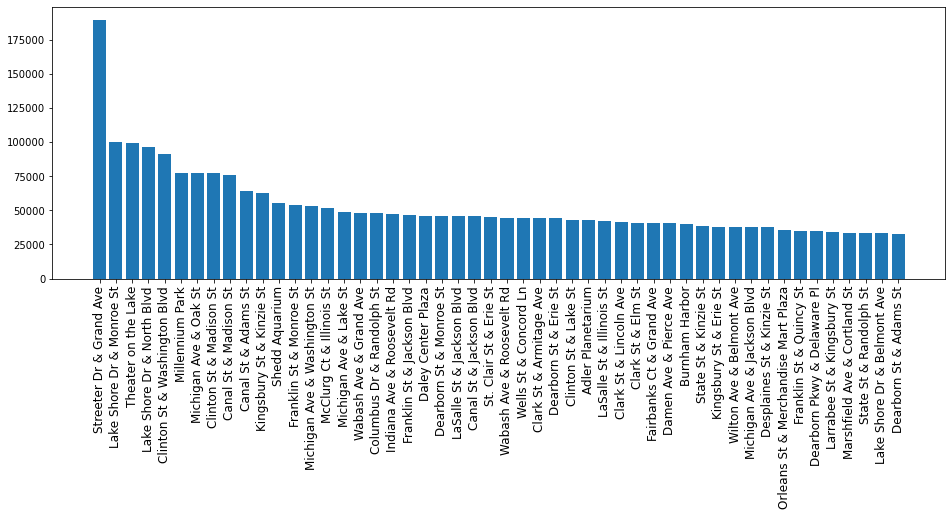

In [27]:
# sorting stations by most activity (started and ended trips)

fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[:50], activity["activities"].iloc[:50])

<BarContainer object of 50 artists>

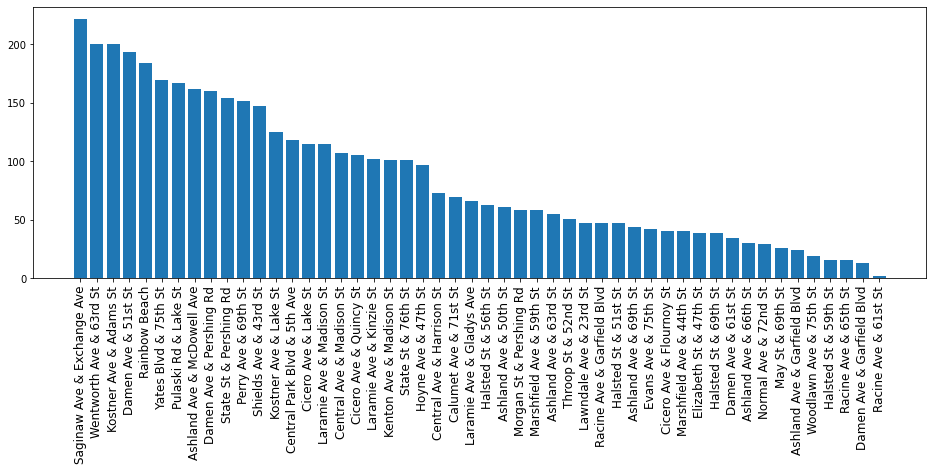

In [28]:
# sorting stations by least activity (started and ended trips)

fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[-50:], activity["activities"].iloc[-50:])

### Why are some stations more popular than others?

We drew the following map to explain why some stations are more frequently used than others. The green dots are the stations that get used the most and the yellow dots are the ones that get used the least. 

If you look closely at the map, you can tell that all the most used stations (green dots) are located within the city centre. Its very likely that this is the reason they get used the most, since people in the city centre rather use bikes (probably in combination with public transportation) than cars, due to traffic and lack of parking spaces.
Also short distances (city tourism) might be another reason why people rather take a bike than use their cars. 

The least used stations (yellow dots) are located further outside the city, where travelling by car is usually more convenient.

In [29]:
# drawing most and least used stations on a map
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

# green dots: most used
# yellow dots: least used

# adding the most used stations
for index, row in activity.iloc[:50].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="green", fill_color="red").add_to(log_map)
    
#add the least used stations
for index, row in activity.iloc[-50:].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="yellow", fill_color="blue").add_to(log_map)
    
log_map

### Conclusion

Analyzing the data showed that there is a connection between frequency of use of the individual stations and their geographical location in the city. The general observed trend is: If stations are located in the city centre or near huge attractions, the more frequently they are used.

### User Type Analysis

In [30]:
# analyse data by customer type

chicago_data["user_type"].value_counts()
subscr_data = chicago_data[chicago_data["user_type"] == "Subscriber"]
cust_data = chicago_data[chicago_data["user_type"] == "Customer"]

#### Subscribers

In [31]:
# make a activity df from a chicago_2016 style df with coordinates

def asActivity(chicago_dataframe, coordinates):
    start_count = chicago_dataframe["start_station_name"].value_counts()
    end_count = chicago_dataframe["end_station_name"].value_counts()
    activity = start_count.to_frame().merge(end_count, left_on=start_count.index, right_on=end_count.index, how="outer")
    activity = activity.rename(columns={"key_0":"station_name","end_station_name":"finished_trips","start_station_name":"started_trips"})
    #set null values to 0
    activity = activity.fillna(value=0)
    #add activity column
    activity["activities"] = activity["finished_trips"]+activity["started_trips"]

    #add coordinates to stations
    coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
    activity = activity.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=activity["station_name"],right_on=coordinates["name"])
    activity = activity.drop(columns=["key_0"])
    #drop stations without location data
    activity = activity.dropna(axis=0)
    activity = activity.sort_values(by="activities",ascending=False)
    return activity

In [32]:
# aggregate subscr_data; started trip = ended trip = 1 activity

subscr_activity = asActivity(subscr_data, coordinates)
subscr_activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Clinton St & Washington Blvd,45907,43054,88961,"(41.883379999999995, -87.64116999999999)"
1,Clinton St & Madison St,39402,33743,73145,"(41.882242, -87.64106600000001)"
2,Canal St & Madison St,33801,37319,71120,"(41.882090999999996, -87.639833)"


<BarContainer object of 50 artists>

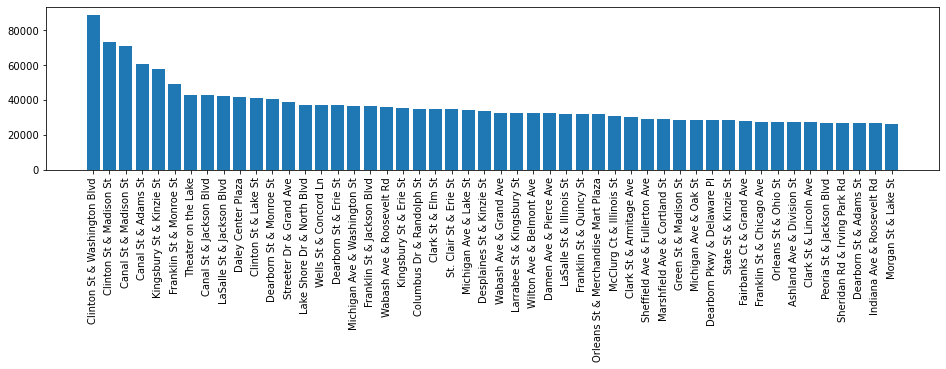

In [33]:
# Graph

fig, ax = plt.subplots(figsize=[16,3])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(subscr_activity["station_name"].iloc[:50],subscr_activity["activities"].iloc[:50])

#### Customers

In [34]:
# aggregate cust_data; started trip = ended trip = 1 activity

cust_activity = asActivity(cust_data, coordinates)
cust_activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Streeter Dr & Grand Ave,70921.0,79703.0,150624.0,"(41.892278000000005, -87.612043)"
1,Lake Shore Dr & Monroe St,40467.0,38723.0,79190.0,"(41.880958, -87.616743)"
2,Lake Shore Dr & North Blvd,27711.0,31202.0,58913.0,"(41.911722, -87.626804)"


<BarContainer object of 50 artists>

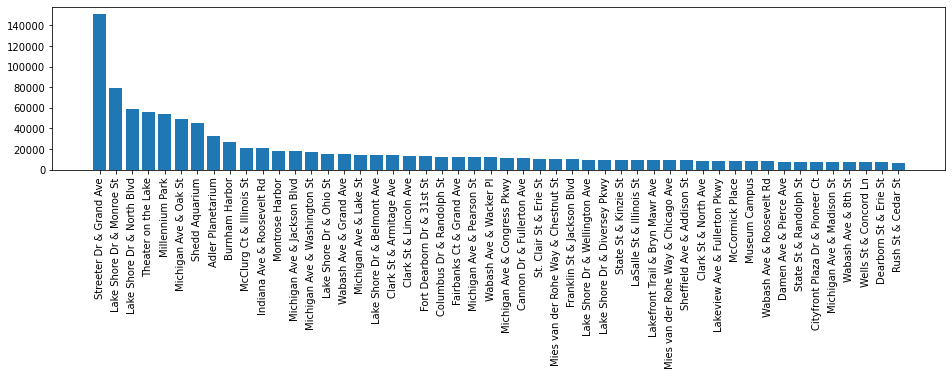

In [35]:
# Graph

fig, ax = plt.subplots(figsize=[16,3])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(cust_activity["station_name"].iloc[:50],cust_activity["activities"].iloc[:50])

### Most used stations for subscribers and costumers
This map illustrates the most used stations for both user types. 
The map shows that customers primarily use stations in the city centre or near huge attractions (tourism) and the subscribers use stations located further on the outside. 

In [36]:
# top 50 stations for subscribers and customers

# orange dots: subscriber
# blue dots: customer
# stations; size --> logarithmic number of activities tours

log_map = folium.Map(location=(41.9, -87.62596070777431),tiles='OpenStreetMap',zoom_start=12, control_scale=True, max_zoom=20)

for index, row in subscr_activity.iloc[:50].iterrows():
    diff_color = "darkorange"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=2).add_to(log_map)
for index, row in cust_activity.iloc[:50].iterrows():
    diff_color = "blue"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=2).add_to(log_map)
# prevent jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))

log_map

### Weather Analysis 

In [37]:
# read weatherdata

weather = pd.read_csv("weather_hourly_chicago.csv", parse_dates = ["date_time"])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  43788 non-null  datetime64[ns]
 1   max_temp   43788 non-null  float64       
 2   min_temp   43788 non-null  float64       
 3   precip     43790 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 MB


In [38]:
# add day of the year feature

weather = weather[weather["date_time"].apply(lambda x:x.year == 2016)]
chicago_data["day_of_year"] = chicago_data["start_time"].apply(lambda x:x.dayofyear)

In [39]:
weather_res = weather.resample("D", on="date_time").agg({'max_temp':'max', 'min_temp': 'min','precip':'sum'})
weather_res["day_of_year"] = weather_res.index.to_series().apply(lambda x:x.dayofyear)
weather_res.value_counts()

max_temp  min_temp  precip  day_of_year
 33.3      25.6     1.0     172            1
 10.0      2.2      0.0     52             1
           5.6      4.0     120            1
                    7.0     119            1
           6.7      2.0     301            1
                                          ..
 25.0      12.2     0.0     143            1
           13.3     0.0     185            1
                            235            1
           14.4     0.0     198            1
-13.9     -20.0     0.0     18             1
Length: 366, dtype: int64

In [40]:
# add weather data to chicago_data

chicago_with_weather = chicago_data.merge(weather_res, right_on=weather_res["day_of_year"], left_on=chicago_data["day_of_year"], how="outer")
chicago_with_weather.head(3)

,key_0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,day_of_year_x,max_temp,min_temp,precip,day_of_year_y
0,91,2016-03-31 23:53:00,4/1/2016 0:07,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,91,18.9,12.8,8.0,91
1,91,2016-03-31 23:46:00,3/31/2016 23:57,128,213,Damen Ave & Chicago Ave,Leavitt St & North Ave,4831,Subscriber,91,18.9,12.8,8.0,91
2,91,2016-03-31 23:42:00,3/31/2016 23:46,350,210,Ashland Ave & Chicago Ave,Ashland Ave & Division St,4232,Subscriber,91,18.9,12.8,8.0,91


In [41]:
# aggregate the trips by start_station and temperature intervals on 5 deg

max_temp_stations = chicago_with_weather.groupby([pd.cut(chicago_with_weather["max_temp"], np.arange(-15, 36, 5)), "start_station_name"]).count()
max_temp_stations = max_temp_stations["key_0"]
max_temp_stations = max_temp_stations.dropna()
max_temp_stations = max_temp_stations.to_frame()
max_temp_stations = max_temp_stations.rename(columns={"key_0":"count"})
max_temp_stations.head(3)

count
max_temp   start_station_name               
(-15, -10] 2112 W Peterson Ave           1.0
           900 W Harrison St             5.0
           Aberdeen St & Jackson Blvd   26.0

In [42]:
# add coordinates

coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
coordinates.head(3)

,id,name,latitude,longitude,dpcapacity,online_date,ziped_coords
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015,"(41.991178000000005, -87.683593)"
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015,"(41.781015999999994, -87.57611999999999)"
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013,"(41.874675, -87.650019)"


### Top 75 stations per Max Temperature

Blue = cold temperature, Red = hot temperature.
Temperature is divided into intervals of 5 deg fom -15 deg to 35 deg. The map below shows the 75 most used stations by started trips for each max temperature per day.

In this map we can observe, that during hot temperatures, the central stations are used primarily. If the weather gets colder, stations farther outside the city are used. 

In [43]:
# draw usage map per temp interval
indexes = max_temp_stations.index
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='Stamen Toner',zoom_start=12, control_scale=True, max_zoom=20)

# add most used
colors = {
    -14:"#5e4fa2",
    -9:"#3288bd",
    -4:"#66c2a5",
    1:"#abdda4",
    6:"#e6f598",
    11:"#fee08b",
    16:"#fdae61",
    21:"#f46d43",
    26:"#d53e4f",
    31:"#9e0142"
}

for temperature in np.arange(-14, 35, 5):
    df = max_temp_stations.loc[temperature].sort_values(by="count").iloc[-75:]
    # print(df)
    df = df.merge(coordinates["ziped_coords"].to_frame(),left_on=df.index,right_on=coordinates["name"],how="left")
    df = df.dropna()
    for index, row in df.iterrows():
        folium.CircleMarker(radius=6, location=row["ziped_coords"], color=colors[temperature],fill=True,weight=2).add_to(log_map)
log_map